## Getting started with the Converse API in Amazon Bedrock

In this notebook, we'll explore the basics of the Converse API in Amazon Bedrock. The Converse or ConverseStream API is a unified structured text API action that allows you simplifying the invocations to Bedrock LLMs, using a universal syntax and message structured prompts for any of the supported model providers.

Let's start by installing or updating boto3. You just need to run this cell the first time.

In [ ]:
!pip3 install -qU boto3

In [2]:
import boto3
import sys
print('Running boto3 version:', boto3.__version__)

Running boto3 version: 1.37.24


Let's define the region and models to use. We can also setup our boto3 client.

In [41]:
# boto3_session = boto3.session.Session()
# region = boto3_session.region_name
region = 'us-east-1'

print('Using region: ', region)
# Replace the hardcoded MODEL_IDS with a dynamic fetch
bedrock = boto3.client(
    service_name='bedrock',
    region_name=region,
)
# Fetch available models dynamically and filter by access
response = bedrock.list_foundation_models()
print(response)
# Filter models that are accessible in the specified region
MODEL_IDS = [
    model['modelId'] for model in response['modelSummaries']
    if 'text' in model['modelId'] and model.get('access', {}).get('status') == 'ACTIVE'
]

print("Accessible text models in the region:", MODEL_IDS)

# Append the claud 7 model arn like above
MODEL_IDS.append("arn:aws:bedrock:us-east-1:183295442349:inference-profile/us.anthropic.claude-3-7-sonnet-20250219-v1:0")
MODEL_IDS.append("amazon.titan-text-premier-v1:0")
MODEL_IDS.append("arn:aws:bedrock:us-east-1:183295442349:inference-profile/us.deepseek.r1-v1:0")
# Now you can use MODEL_IDS in your invoke_bedrock_model function
print(f'Available models: {MODEL_IDS}')

bedrock = boto3.client(
    service_name = 'bedrock-runtime',
    region_name = region,
    )

Using region:  us-east-1
{'ResponseMetadata': {'RequestId': '350e38a6-3979-4127-97af-b5522995091f', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Wed, 16 Apr 2025 17:27:55 GMT', 'content-type': 'application/json', 'content-length': '41800', 'connection': 'keep-alive', 'x-amzn-requestid': '350e38a6-3979-4127-97af-b5522995091f'}, 'RetryAttempts': 0}, 'modelSummaries': [{'modelArn': 'arn:aws:bedrock:us-east-1::foundation-model/amazon.titan-tg1-large', 'modelId': 'amazon.titan-tg1-large', 'modelName': 'Titan Text Large', 'providerName': 'Amazon', 'inputModalities': ['TEXT'], 'outputModalities': ['TEXT'], 'responseStreamingSupported': True, 'customizationsSupported': [], 'inferenceTypesSupported': ['ON_DEMAND'], 'modelLifecycle': {'status': 'ACTIVE'}}, {'modelArn': 'arn:aws:bedrock:us-east-1::foundation-model/amazon.titan-image-generator-v1:0', 'modelId': 'amazon.titan-image-generator-v1:0', 'modelName': 'Titan Image Generator G1', 'providerName': 'Amazon', 'inputModalities': ['TEXT', 'IM

We're now ready to setup our Converse API action in Bedrock. Note that we use the same syntax for any model, including the messages-formatted prompts, and the inference parameters. Also note that we read the output in the same way independently of the model used.

Optionally, we could define additional model specific request fields that are not common across all providers. For more information on this check the Bedrock Converse API documentation.

### Converse for one-shot invocations

In [4]:
def invoke_bedrock_model(client, id, prompt, max_tokens=2000, temperature=0, top_p=0.9):
    response = ""
    try:
        response = client.converse(
            modelId=id,
            messages=[
                {
                    "role": "user",
                    "content": [
                        {
                            "text": prompt
                        }
                    ]
                }
            ],
            inferenceConfig={
                "temperature": temperature,
                "maxTokens": max_tokens,
                "topP": top_p
            }
            #additionalModelRequestFields={
            #}
        )
    except Exception as e:
        print(e)
        result = "Model invocation error"
    try:
        result = response['output']['message']['content'][0]['text'] \
        + '\n--- Latency: ' + str(response['metrics']['latencyMs']) \
        + 'ms - Input tokens:' + str(response['usage']['inputTokens']) \
        + ' - Output tokens:' + str(response['usage']['outputTokens']) + ' ---\n'
        return result
    except Exception as e:
        print(e)
        result = "Output parsing error"
    return result

Finally, we can test our invocation.

In this example, we run the same prompt across all the text models supported in Bedrock by the time of writing this example.

In [5]:
prompt = ("What is the capital of Italy?")
print(f'Prompt: {prompt}\n')

for i in MODEL_IDS:
    response = invoke_bedrock_model(bedrock, i, prompt)
    print(f'Model: {i}\n{response}')

Prompt: What is the capital of Italy?

Model: arn:aws:bedrock:us-east-1:183295442349:inference-profile/us.anthropic.claude-3-7-sonnet-20250219-v1:0
The capital of Italy is Rome. It's not only the capital but also the largest city in Italy, with a rich history dating back thousands of years. Rome served as the capital of the Roman Empire and is home to numerous historical landmarks including the Colosseum, the Roman Forum, and Vatican City.
--- Latency: 2280ms - Input tokens:14 - Output tokens:65 ---

Model: amazon.titan-text-premier-v1:0
Rome is the capital of Italy. It is a city with a rich history, culture, and architecture. Rome is home to many famous landmarks, including the Colosseum, the Roman Forum, and the Vatican City. The city has a population of over 4 million people and is a popular tourist destination.
--- Latency: 1468ms - Input tokens:7 - Output tokens:62 ---

Model: arn:aws:bedrock:us-east-1:183295442349:inference-profile/us.deepseek.r1-v1:0


The capital of Italy is **

### ConverseStream for streaming invocations

We can also use the Converse API for streaming invocations. In this case we rely on the ConverseStream action.

In [ ]:
def invoke_bedrock_model_stream(client, id, prompt, max_tokens=2000, temperature=0, top_p=0.9):
    response = ""
    response = client.converse_stream(
        modelId=id,
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "text": prompt
                    }
                ]
            }
        ],
        inferenceConfig={
            "temperature": temperature,
            "maxTokens": max_tokens,
            "topP": top_p
        }
    )
    # Extract and print the response text in real-time.
    for event in response['stream']:
        if 'contentBlockDelta' in event:
            chunk = event['contentBlockDelta']
            sys.stdout.write(chunk['delta']['text'])
            sys.stdout.flush()
    return

In [48]:
def invoke_bedrock_model_stream(client, id, prompt, max_tokens=2000, temperature=0, top_p=0.9):
    try:
        response = client.converse_stream(
            modelId=id,
            messages=[
                {
                    "role": "user",
                    "content": [
                        {
                            "text": prompt
                        }
                    ]
                }
            ],
            inferenceConfig={
                "temperature": temperature,
                "maxTokens": max_tokens,
                "topP": top_p
            }
        )
        # Process the streaming response
        for event in response['stream']:
            if 'contentBlockDelta' in event:
                chunk = event['contentBlockDelta']
                # Print the chunk for debugging
                # print("Chunk received:", chunk)

                # Handle reasoningContent if present
                if 'delta' in chunk and 'reasoningContent' in chunk['delta']:
                    reasoning_text = chunk['delta']['reasoningContent'].get('text', '')
                    if reasoning_text:
                        # Stream output as Reasoning
                        sys.stdout.write(reasoning_text)
                        sys.stdout.flush()

                # Handle text if present
                if 'delta' in chunk and 'text' in chunk['delta']:
                    sys.stdout.write(chunk['delta']['text'])
                    sys.stdout.flush()
    except Exception as e:
        print(f"Error invoking model {id} with streaming: {e}")

In [49]:
bedrock = boto3.client(
    service_name = 'bedrock-runtime',
    region_name = region,
    )
prompt = ("What is the capital of Italy?")
print(f'Prompt: {prompt}\n')

for i in MODEL_IDS:
    print(f'\n\nModel: {i}')
    invoke_bedrock_model_stream(bedrock, i, prompt)

Prompt: What is the capital of Italy?



Model: arn:aws:bedrock:us-east-1:183295442349:inference-profile/us.anthropic.claude-3-7-sonnet-20250219-v1:0
The capital of Italy is Rome. It's not only the capital but also the largest city in Italy, with a rich history dating back thousands of years. Rome served as the capital of the Roman Empire and is home to numerous historical landmarks including the Colosseum, Roman Forum, and Vatican City.

Model: amazon.titan-text-premier-v1:0
Rome is the capital city of Italy. It is also the largest city in Italy. Rome is also known as the "Eternal City" because it has been a major human settlement for over 2,500 years. Rome is located in the central-western portion of the Italian Peninsula, on the Tiber River. Rome is a major global city and a popular tourist destination, known for its history, art, architecture, and cuisine. Some of the most famous landmarks in Rome include the Colosseum, the Roman Forum, the Pantheon, the Trevi Fountain, and the Vat

As you can see, the Converse API allow us to easily run the invocations with the same syntax across all the models.

# https://github.com/aws/aws-sdk/issues/810
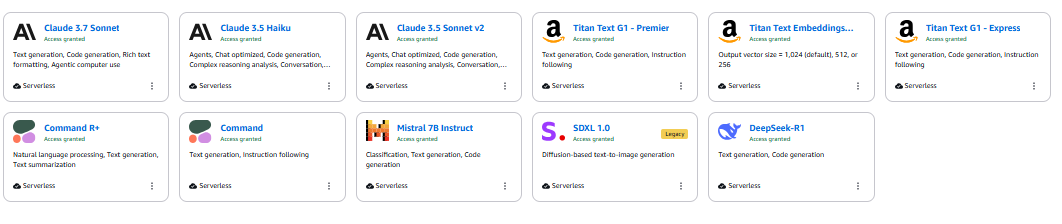